# 05-02 과대적합과 과소적합
## 과대적합
- 훈련 세트를 과도하게 학습하게 한 상태
- 훈련 세트에서의 정확도는 높지만, 검증 세트에서의 정확도는 비교적 낮다. 
- (훈련, 검증 세트간의 차이가 크다, 분산이 크다)

#### 과대적합으로 만드는 방법
1. 뉴런의 수를 증가시키는 방법
2. 층의 수를 증가시키는 방법

## 과소적합
- 훈련 세트를 많이 학습시키지 않은 상태
- 훈련 세트와 검증 세트의 차이가 크지는 않지만, 전반적으로 낮은 정확도를 보인다.
- 편향이 크다
 
# 어떻게 확인하는가?
- (정확도, 훈련 세트의 크기)의 그래프로 확인
- (에포크, 손실 함수)의 그래프로 확인 (주로 이것으로 확인한다.)


# 적절한 편향-분산 트레이드오프를 선택합니다.

In [22]:
import numpy as np
class SingleLayer:
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []                    # 손실을 저장하는 리스트
        self.val_losses = []                                                    # 검증 세트의 손실 저장
        self.w_history = []                 # 가중치를 기록하기 위한 변수
        self.lr = learning_rate             # 학습률
    
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b     # 직선의 방정식을 계산
        # z = w1*x1 + w2*x2 ''' wn*xn + b
        return z
    
    def backprop(self, x, err):
        # 가중치와 절편에 대한 그레이디언트를 계산, 반환
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    # 확률적 경사하강법을 적용한 훈련법
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])        # 가중치를 초기화 합니다.
        self.b = 0                          # 절편을 초기화 합니다.
        self.w_history.append(self.w.copy())# 가중치를 기록합니다.
        np.random.seed(42)                  # 랜덤시드 지정
        for i in range(epochs):             # epochs만큼 반복합니다.
            loss = 0                        # 손실을 0으로 초기화합니다.
            indexes = np.random.permutation(np.arange(len(x))) # 확률적 경사하강법을 적용하기 위한 인덱스 섞기
            for i in indexes:
                z = self.forpass(x[i])       # 정방향 계산
                a = self.activation(z)      # 활성화 함수 적용
                err = -(y[i] - a)            # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= self.lr * w_grad  # 가중치 업데이트, 학습률 반영
                self.b -= b_grad            # 절편 업데이트

                self.w_history.append(self.w.copy()) # 가중치를 기록합니다.
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
            self.update_val_loss(x_val, y_val)                                  # 검증 세트에 대한 손실 계산
    
    def activation(self, z):
        z = np.clip(z, -100, None)          # 안전한 np.exp() 계산을 위한 clip함수
        a = 1 / (1 + np.exp(-z))            # 시그모이드 계산
        return a
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]    # 선형 함수 적용
        return np.array(z) > 0                  # 계단 함수 적용
    
    def score(self, x, y):                      # 성능을 보여주는 메서드
        return np.mean(self.predict(x) == y)
    def update_val_loss(self, x_val, y_val):                                    # 검증 세트 손실을 업데이트
        '''
        만들어진 모델에 대해 검증 세트(전부)로 손실을 계산한 후 평균을 낸다
        '''
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):                                            # 모든 검증세트에 대해 반복
            z = self.forpass(x_val[i])                                          # 정방향 계산
            a = self.activation(z)                                              # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)                                      # 안전한 log계산을 위한 clip 함수 적용
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))          # val_loss에 더해준다.
        self.val_losses.append(val_loss/len(y_val))                             # 평균을 낸다.

In [23]:
# 데이터 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 데이터 나누기 (훈련 세트, 테스트 세트)
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 데이터 나누기 (훈련 세트, 검증 세트)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 전처리
train_mean = np.mean(x_train, axis=0)   # train_mean = u
train_std = np.std(x_train, axis=0)     # train_std = s

## 훈련 데이터 전처리
x_train_scaled = (x_train - train_mean) / train_std   # x_train_scaled = z
## 검증 데이터 전처리
x_val_scaled = (x_val - train_mean) / train_std
## 테스트 데이터 전처리
x_test_scaled = (x_test - train_mean) / train_std


In [24]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
layer3.score(x_val_scaled, y_val)

0.967032967032967

## 손실값으로 그래프를 그려 에포크 횟수 지정하기

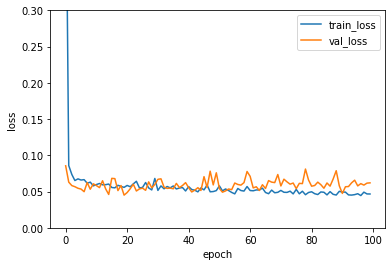

In [25]:
import matplotlib.pyplot as plt
plt.ylim(0,0.3)
plt.plot(layer3.losses)       # 훈련 데이터 손실
plt.plot(layer3.val_losses)   # 검증 데이터 손실
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


- 위 그래프를 통해 검증 손실이 대략 20번째 에포크 이후 훈련 세트보다 높아진다. -> 최적점

### 조기종료한 경우 (적당한 에포크에서 훈련을 마쳤을 경우) -> 더 높은 정확도를 보여준다

In [26]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978